In [1]:
import argparse
import sys
import os
import logging
import numpy as np

sys.path.insert(0, '../network')
from network import *
from transfer_functions import ErrorFunction, ReLU
from sequences import Sequence
from connectivity import *
from noise import WhiteNoise

sys.path.insert(0, '../scripts')
from simulation import *

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

Network and pattern parameters

In [71]:
# Network
N_E = 20000
p = 0.04
K = N_E*p
A_EE = 3.5
T = 1.0
dt = 1e-3

# Patterns
P = 16

Patterns

In [3]:
patterns = np.random.RandomState(seed=1).normal(0,1,size=(P,N_E))
sequence = Sequence()
sequence.inputs = patterns

Build EE connectivity (two populations)

In [4]:
# Structural connectivity
k = np.random.RandomState(seed=2).binomial(N_E, p, size=N_E)
ji = build_ji(k, N_E)

100%|██████████| 20000/20000 [00:11<00:00, 1801.47it/s]


In [5]:
# Store pattern associations using the threshold plasticity rule
plasticity = ThresholdPlasticityRule(x_f=1.5, q_f=0.8)
indptr, indices, data_p0 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K, p=0)
_, _, data_p1 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K, p=1)

100%|██████████| 20000/20000 [00:04<00:00, 4608.96it/s]


In [6]:
# Adjust subpopulation weights
data_p1_copy = np.asarray(data_p1).copy()
data_p0_copy = np.asarray(data_p0).copy()
reweight(indptr, indices, data_p1_copy, # Asymmetric
         A_EE, N_E, w_11=1, w_12=1, w_21=0, w_22=0) # 1, 1, 0, 0
reweight(indptr, indices, data_p0_copy, # Symmetric
         A_EE, N_E, w_11=0, w_12=0, w_21=1, w_22=1) # 0, 0, 1, 1
data = data_p1_copy + data_p0_copy
W = cp.sparse.csr_matrix(
    (cp.asarray(data), cp.asarray(indices), cp.asarray(indptr)),
    shape=(N_E,N_E),
    dtype=cp.float32)

20000it [00:00, 102237.88it/s]
20000it [00:00, 105066.81it/s]


In [7]:
conn_EE = Connectivity()
conn_EE.W = W.get()
conn_EE.K = K

Build network and connectivity

Simulate

In [72]:
q = []

I_ext = [
    (-4.0, 1),
    (0.5, -0.5),
]

for (I_ext_1, I_ext_2) in I_ext:

    exc_phi = ReLU(g=12)
    exc = Population(N_E, tau=2e-2, phi=exc_phi.phi)
    
    # Rate formulation 2: $ \frac{dx}{dt} = -x + \sum_{j} J_{ij} /phi(x_j) $
    net = RateNetwork(exc, c_EE=conn_EE, formulation=2)
    
    # Simulate
    r0 = np.zeros(exc.size)
    r0[:] = exc.phi(plasticity.f(patterns[0,:]))
    
    r_ext_dc = np.concatenate((
        np.full(shape=(int(N_E/2)), fill_value=I_ext_1, dtype=np.float32),
        np.full(shape=(int(N_E/2)), fill_value=I_ext_2, dtype=np.float32)))
    
    def r_ext(t):
        i = int(t/dt)
        return r_ext_dc
    
    net.simulate(T, r0=r0, r_ext=r_ext)
    
    ## Correlations
    correlations = sequence.overlaps(net, exc, plasticity=plasticity, correlation=True)
    q.append(correlations)

INFO:network:Integrating network dynamics
[========================================================================] 100%
INFO:sequences:Computing correlations
100%|██████████| 16/16 [00:07<00:00,  2.17it/s]
INFO:network:Integrating network dynamics
[========================================================================] 100%
INFO:sequences:Computing correlations
100%|██████████| 16/16 [00:07<00:00,  2.26it/s]


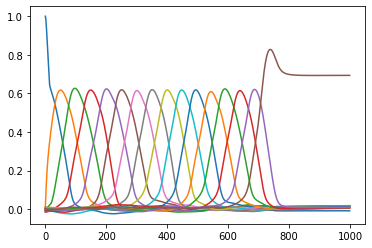

In [73]:
for overlap in q[0]:
    plt.plot(overlap);

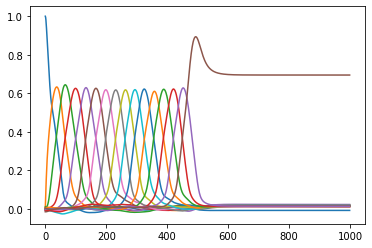

In [74]:
for overlap in q[1]:
    plt.plot(overlap);

Field statistics

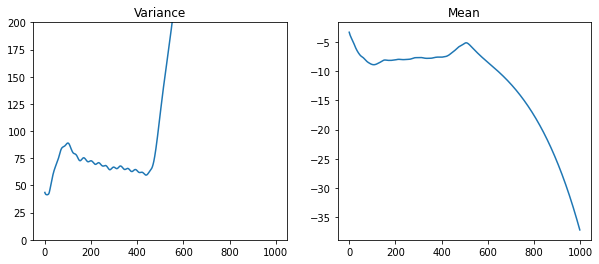

In [75]:
# Field statistics
M = np.mean(net.exc.phi(net.exc.state)**2, axis=0)
field = conn_EE.W.dot(net.exc.phi(net.exc.state))
field_var = field.var(axis=0)
field_mean = field.mean(axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(field_var)
ax[1].plot(field_mean)
ax[0].set_ylim([0,200])
ax[0].set_title("Variance")
ax[1].set_title("Mean");